# Load data, models and define other parameters

## Define folders, features to use

In [55]:
import pandas as pd
from joblib import load
import numpy as np

# this can be changed
model_type = "optical"
# region = "Antarctica"
region = "Greenland"

########################################################################################

def test_train_split_day_batches(data, test_size=0.2, random_seed=26):
    cycle_day = 20
    testing_days = int(test_size * cycle_day)

    if testing_days == 0:
        testing_days = 1

    datetimes = pd.to_datetime(data["cFileID"].apply(lambda x: x[0:10]), format="%Y-%m-%d")

    # get the earliest date in the dataset
    earliest_date = datetimes.min()
    days_since_earliest_date = (datetimes - earliest_date).dt.days

    # get the unique days list and shuffle them
    unique_days = days_since_earliest_date.unique()
    # np.random.seed(random_seed)
    # np.random.shuffle(unique_days)

    test_data = data[days_since_earliest_date.isin(unique_days[0::cycle_day])]
    for testing_day in range(1, testing_days):
        test_data = pd.concat([test_data, data[days_since_earliest_date.isin(unique_days[testing_day::cycle_day])]], axis=0)

    train_data = data[~data.index.isin(test_data.index)]

    return train_data, test_data

data_folder = {
    "Greenland": "./2013_2017_DATA/",
    "Antarctica": "./JASMIN_tests/Antarctica/merged_features/"
}

coord_limits = {
    "Greenland": {
        "lat": (55, 88),
        "lon": (-80, -10)
    },
    "Antarctica": {
        "lat": (-90, -60),
        "lon": (-180, 180)
    }
}

features = {
    "infrared": [
        'band_25', 'band_27', 'band_36', 'BTD85_11', 'BTD73_11', 'BT73',
       'BTD12_11', 'BTD39_11', 'mLST_night', 'mSZA'
    ],
    "optical": [
        'band_7', 'band_18', 'band_20', 'band_25', 'band_26', 'band_27',
       'band_28', 'band_29', 'mSZA', 'mCloudTopPressure'
    ]
}

model_save_folder = "./2013_2017_DATA/trained_models/"
model_save_names = {
    "infrared": "RF infrared (night-only)_run_57.joblib",
    "optical": "RF optical (day-only)_run_57.joblib"
}

## Read data

In [56]:
data = pd.read_csv(data_folder[region] + f"clean_{model_type}_features.csv")
labels = pd.read_csv(data_folder[region] + f"clean_{model_type}_labels.csv")

# remove nan values, if any
data = data.dropna()
labels = labels.loc[data.index]

# save latitudes and longitudes for later
latitudes = data["mLat"]
longitudes = data["mLong"]

# save day of year for later
day_of_year = data['day_of_year']

# save MODIS phase predictions
modis_phase = np.where(data['mWater'].values == 1, 1, 0) +\
                np.where(data['mIce'].values == 1, 2, 0) +\
                np.where(data['mUndetermined'].values == 1, 3, 0)

if region == 'Greenland':
    # save cloud properties "cCloudTopHeight", "cCloudGeometricalThickness", "cColumnOpticalDepth"
    cloud_geom_thickness = labels['cCloudGeometricalThickness']
    cloud_top_height = labels['cCloudTopHeight']
    cloud_optical_depth = labels['cColumnOpticalDepth']


## Split data into train and test sets

In [57]:
fraction_of_data = 0.1

# only use the features that are in the model
train_data, test_data = test_train_split_day_batches(data, test_size=fraction_of_data)
train_data, test_data = train_data[features[model_type]], test_data[features[model_type]]
train_labels, test_labels = test_train_split_day_batches(labels, test_size=fraction_of_data)
train_labels, test_labels = train_labels["class"], test_labels["class"]

# only keep lats and longs for the test data
latitudes = latitudes.loc[test_data.index]
longitudes = longitudes.loc[test_data.index]

# restrict data to coord limits
latitude_mask = (latitudes >= coord_limits[region]["lat"][0]) & (latitudes <= coord_limits[region]["lat"][1])
longitude_mask = (longitudes >= coord_limits[region]["lon"][0]) & (longitudes <= coord_limits[region]["lon"][1])
test_data = test_data[latitude_mask & longitude_mask]
test_labels = test_labels.loc[test_data.index]



## Load model

In [58]:
clf = load(model_save_folder + model_save_names[model_type])

## Predict

In [59]:
predicted_phase = clf.predict(test_data)

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtyp

## Make prediction accuracy dataframe

In [60]:
prediction_accuracy = pd.DataFrame(columns=['lat', 'lng', 'predicted', 'actual'])
prediction_accuracy['lat'] = latitudes[test_data.index]
prediction_accuracy['lng'] = longitudes[test_data.index]
prediction_accuracy['predicted'] = predicted_phase
prediction_accuracy['actual'] = test_labels
if region == 'Greenland':
    prediction_accuracy['cloud_top_height'] = cloud_top_height.loc[test_data.index]
    prediction_accuracy['cloud_geom_thickness'] = cloud_geom_thickness.loc[test_data.index]
    prediction_accuracy['cloud_optical_depth'] = cloud_optical_depth.loc[test_data.index]
    prediction_accuracy['modis_phase'] = modis_phase[test_data.index]

    # remove all rows for which cloud_optical_depth is < 0
    prediction_accuracy = prediction_accuracy[prediction_accuracy['cloud_optical_depth'] >= 0]

# print the overall accuracy
print(f"Overall accuracy: {sum(prediction_accuracy['predicted'] == prediction_accuracy['actual']) / len(prediction_accuracy)}")

# plot = prediction_accuracy.plot.scatter(x='lng', y='lat', c='predicted', colormap='viridis')

print(len(prediction_accuracy))

Overall accuracy: 0.8907367622899027
79130


## Hexagonal grid test

In [120]:
import geopandas as gpd
import h3pandas as h3pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

resolution = 3

# convert the latitudes and longitudes to hexagons
dfh3 = prediction_accuracy.h3.geo_to_h3(resolution)
dfh3.head()

# dfh3 = dfh3.rename(columns={f'h3_{resolution}': 'h3'})

# count the samples in each hexagon
hexagon_count = dfh3.groupby(f'h3_{resolution:02d}').size().reset_index()
hexagon_count = pd.DataFrame(hexagon_count)
hexagon_count = hexagon_count.rename(columns={0: 'count'})
# display(hexagon_count.head())
print(hexagon_count.shape)

min_number_of_samples = 1000
not_enough_samples = hexagon_count['count'] < min_number_of_samples
print(f"Number of hexagons with less than {min_number_of_samples} samples: {not_enough_samples.sum()}")

def get_accuracy_score(hexagon_df):
    return (hexagon_df.predicted == hexagon_df.actual).sum() / len(hexagon_df)


dfh3 = dfh3.drop(columns=['lat', 'lng']).groupby(f'h3_{resolution:02d}').apply(get_accuracy_score)#.reset_index()
dfh3 = pd.DataFrame(dfh3)
dfh3 = dfh3.rename(columns={0: 'accuracy'})

# remove the hexagons with less than 100 samples
dfh3 = dfh3[dfh3.index.isin(hexagon_count[~not_enough_samples][f'h3_{resolution:02d}'])]
print(dfh3.shape)

# display(dfh3.head())

gdfh3 = dfh3.h3.h3_to_geo_boundary()
# display(gdfh3.head())

# read bamber.5km97.dat file which contains Antarctica topographic information
bamber = pd.read_csv("bamber.5km97.dat", delim_whitespace=True, header=None, names=['lat', 'lon', 'elevation', 'diff'])
bamber.head()
print(bamber.shape)
# set all 999 values to nan
bamber.elevation = bamber.elevation.replace(999, np.nan)

# convert to km
bamber.elevation = bamber.elevation / 1000

X, Y = np.meshgrid(np.linspace(-180, 180, 1121), np.linspace(-90, -60, 1121))
Z = interpolate.griddata((bamber.lon, bamber.lat), bamber.elevation, (X, Y), method='linear')






(940, 2)
Number of hexagons with less than 1000 samples: 94
(846, 1)
(1256641, 4)


/var/folders/dj/84f9z8ln22g3pqsfd56x81m00000gn/T/ipykernel_40150/1299401928.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors)


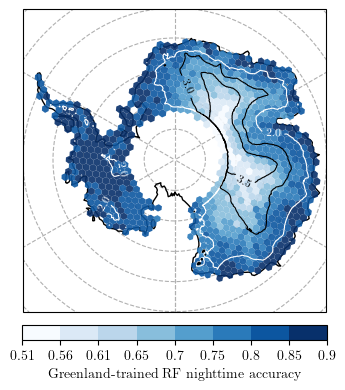

In [148]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'

# projection = ccrs.Orthographic(central_latitude=74, central_longitude=-40)
projection = ccrs.SouthPolarStereo()
projection = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=-90)

fig, ax = plt.subplots(figsize=(4.3, 4.3), subplot_kw={'projection': projection})
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle="dashed", zorder=0)
ax.coastlines(resolution='110m')

# make colormap based on the accuracy values
n_colors = 8
cmap = plt.cm.get_cmap('Blues', n_colors)
min_acc = dfh3.accuracy.min()
max_acc = dfh3.accuracy.max()
normalized_accuracy = (dfh3.accuracy - min_acc) / (max_acc - min_acc)
normalized_accuracy = normalized_accuracy.values

for i in range(len(gdfh3)):
    ax.add_geometries(gdfh3.geometry.values[i],
                      facecolor=cmap(normalized_accuracy[i]),
                      alpha=0.9,
                      crs=ccrs.PlateCarree())

# ax.set_extent([-60, -20, 55, 85], crs=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, -90], crs=ccrs.PlateCarree())

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
# sm._A = []
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Greenland-trained RF nighttime accuracy')
cbar.set_ticks(np.linspace(0, 1, n_colors + 1))
cbar.set_ticklabels(np.linspace(min_acc, max_acc, n_colors + 1).round(2))

# plot the topography
CS = ax.contour(X, Y,
            Z,
            colors=['white', 'k', 'k'],
            levels=[2, 3, 3.5],
            linewidths=0.8,
            antialiased=True,
            # corner_mask=False,
            transform=ccrs.PlateCarree()
)

# add labels to contours
plt.clabel(CS, inline=True, fontsize=8, fmt='%1.1f')

# save to pdf
plt.savefig(f"{model_type}_{region}_accuracy_map.pdf", bbox_inches='tight')

## Test cloud properties from CALIOP

/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alexandrudobra/anaconda3/envs/MPhys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

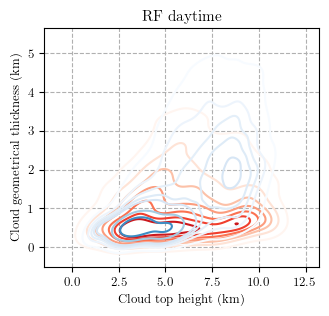

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'

# only keep prediction_accuracy rows with cloud_geom_thickness >= 0.1 and cloud_top_height >= 0.7
prediction_accuracy = prediction_accuracy[(prediction_accuracy['cloud_geom_thickness'] >= 0.1) & (prediction_accuracy['cloud_geom_thickness'] < 5) &(prediction_accuracy['cloud_top_height'] < 15)]

diagonal = np.linspace(0.1, 10, 100)

# only keep prediction_accuracy rows with cloud_optical_depth >= 0.007 and cloud_top_height >= 0.7
# prediction_accuracy = prediction_accuracy[(prediction_accuracy['cloud_optical_depth'] >= 0.007) & (prediction_accuracy['cloud_top_height'] >= 0.7)]

actual_cloud_mask = (prediction_accuracy['actual'] == 1) | (prediction_accuracy['actual'] == 2)

x_feature = 'cloud_top_height'
y_feature = 'cloud_geom_thickness'

fig, ax = plt.subplots(figsize=(3.55, 3.1))

sns.kdeplot(
    ax=ax,
    data=prediction_accuracy[actual_cloud_mask & (prediction_accuracy['predicted'] != prediction_accuracy['actual'])],
    x=x_feature,
    y=y_feature,
    # bins=15,
    # cbar=True,
    cmap='Reds',
    # alpha=0.7,
    fill=False,
    levels=8,
    # thresh=None,
    log_scale=(False, False),
    label="Incorrectly classified",
    # element="step",
)

sns.kdeplot(
    ax=ax,
    data=prediction_accuracy[actual_cloud_mask & (prediction_accuracy['predicted'] == prediction_accuracy['actual'])],
    x=x_feature,
    y=y_feature,
    # bins=15,
    # cbar=True,
    cmap='Blues',
    # alpha=0.7,
    fill=False,
    levels=8,
    # thresh=None,
    log_scale=(False, False),
    label="Correctly classified",
    # element="step",
)

# plot the diagonal
# plt.plot(diagonal, diagonal, 'k--')

# get the last color in the Blues and Reds colormaps
blue_color = sns.color_palette("Blues", 8)[-1]
red_color = sns.color_palette("Reds", 8)[-1]

plt.gca().set_xlabel("Cloud top height (km)")
plt.gca().set_ylabel("Cloud geometrical thickness (km)")
# plt.gca().set_ylabel("")
handles = [Line2D([0], [0], color=color) for color in [blue_color, red_color]]
# ax.legend(handles, ["Correctly classified", "Incorrectly classified"], loc='lower left')

# set dashed grid
plt.gca().grid(linestyle='--')

ax.set_title(f"RF daytime", fontsize=11)
    
fig.savefig(f"cloud_properties_{model_type}.pdf", bbox_inches='tight')

## Print statistics per season

In [94]:
day_of_year = day_of_year.loc[test_data.index]

season_day_of_year_lists = {
    'spring': np.arange(60, 152),
    'summer': np.arange(152, 244),
    'autumn': np.arange(244, 335),
    'winter': np.concatenate((np.arange(335, 366), np.arange(0, 60))),
    'year_round': np.arange(0, 366)
}

for season, days in season_day_of_year_lists.items():
    print(f"Season: {season}")
    season_mask = day_of_year.isin(days)
    print(f"Number of samples: {season_mask.sum()}")
    print(f"Accuracy: {sum(test_labels.loc[season_mask] == predicted_phase[season_mask]) / season_mask.sum():.4g}")

    # print the number of clear pixels in this season, along with the number of predicted clear pixels
    clear_mask = (test_labels == 0) & season_mask
    print(f"Number of clear pixels (CALIOP): {clear_mask.sum()}, {clear_mask.sum()/sum(season_mask):.4g}")
    predicted_clear_mask = (predicted_phase == 0) & season_mask
    print(f"Number of predicted clear pixels: {predicted_clear_mask.sum()}, {predicted_clear_mask.sum()/sum(season_mask):.4g}")

    # print the number of water pixels in this season, along with the number of predicted water pixels
    water_mask = (test_labels == 1) & season_mask
    print(f"Number of water pixels (CALIOP): {water_mask.sum()}, {water_mask.sum()/sum(season_mask):.4g}")
    predicted_water_mask = (predicted_phase == 1) & season_mask
    print(f"Number of predicted water pixels: {predicted_water_mask.sum()}, {predicted_water_mask.sum()/sum(season_mask):.4g}")

    # print the number of ice pixels in this season, along with the number of predicted ice pixels
    ice_mask = (test_labels == 2) & season_mask
    print(f"Number of ice pixels (CALIOP): {ice_mask.sum()}, {ice_mask.sum()/sum(season_mask):.4g}")
    predicted_ice_mask = (predicted_phase == 2) & season_mask
    print(f"Number of predicted ice pixels: {predicted_ice_mask.sum()}, {predicted_ice_mask.sum()/sum(season_mask):.4g}")


Season: spring
Number of samples: 29701
Accuracy: 0.8759
Number of clear pixels (CALIOP): 15480, 0.5212
Number of predicted clear pixels: 15948, 0.537
Number of water pixels (CALIOP): 3263, 0.1099
Number of predicted water pixels: 3395, 0.1143
Number of ice pixels (CALIOP): 10958, 0.3689
Number of predicted ice pixels: 10358, 0.3487
Season: summer
Number of samples: 40980
Accuracy: 0.8994
Number of clear pixels (CALIOP): 18619, 0.4543
Number of predicted clear pixels: 19533, 0.4766
Number of water pixels (CALIOP): 11612, 0.2834
Number of predicted water pixels: 11965, 0.292
Number of ice pixels (CALIOP): 10749, 0.2623
Number of predicted ice pixels: 9482, 0.2314
Season: autumn
Number of samples: 7499
Accuracy: 0.9009
Number of clear pixels (CALIOP): 2887, 0.385
Number of predicted clear pixels: 2860, 0.3814
Number of water pixels (CALIOP): 1844, 0.2459
Number of predicted water pixels: 1845, 0.246
Number of ice pixels (CALIOP): 2768, 0.3691
Number of predicted ice pixels: 2794, 0.3726


## Get feature importances

In [4]:
import time
from sklearn.inspection import permutation_importance

result = {}

# suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for model_type in ["infrared", "optical"]:

    print(f"Load data for {model_type}")
    data = pd.read_csv(data_folder[region] + f"clean_{model_type}_features.csv")
    labels = pd.read_csv(data_folder[region] + f"clean_{model_type}_labels.csv")

    # remove nan values, if any
    data = data.dropna()
    labels = labels.loc[data.index]

    fraction_of_data = 0.1

    # only use the features that are in the model
    train_data, test_data = test_train_split_day_batches(data, test_size=fraction_of_data)
    train_data, test_data = train_data[features[model_type]], test_data[features[model_type]]
    train_labels, test_labels = test_train_split_day_batches(labels, test_size=fraction_of_data)
    train_labels, test_labels = train_labels["class"], test_labels["class"]

    del data, labels, train_data, train_labels

    print(f"Model type: {model_type}. Loading model.")
    RF = load(model_save_folder + model_save_names[model_type])

    print("Starting permutation importance computation")
    t0 = time.time()
    RF.set_params(verbose=0)
    result[model_type] = permutation_importance(RF, test_data.values, test_labels.values, n_repeats=10, random_state=42)
    t1 = time.time()
    computation_time = t1 - t0
    print("Finished permutation importance computation, time:", computation_time)
    print(f"Feature importances (name, mean, std): {zip(test_data.columns, result[model_type].importances_mean, result[model_type].importances_std)}")




Load data for infrared
Model type: infrared. Loading model.
Starting permutation importance computation
Finished permutation importance computation, time: 106.80579900741577
Feature importances (name, mean, std): <zip object at 0x28367f100>
Load data for optical
Model type: optical. Loading model.
Starting permutation importance computation
Finished permutation importance computation, time: 60.09221386909485
Feature importances (name, mean, std): <zip object at 0x16a8a4c40>


### Plot permutation importances

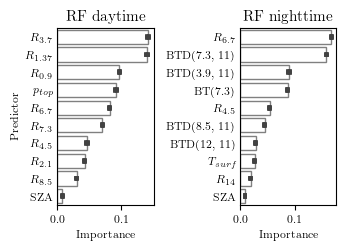

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern'

feature_name_dict = {
    'infrared': {
        'band_25': '$R_{4.5}$',
        'band_27': '$R_{6.7}$',
        'band_36': '$R_{14}$',
        'BTD85_11': 'BTD(8.5, 11)',
        'BTD73_11': 'BTD(7.3, 11)',
        'BT73': 'BT(7.3)',
        'BTD12_11': 'BTD(12, 11)',
        'BTD39_11': 'BTD(3.9, 11)',
        'mLST_night': '$T_{surf}$',
        'mSZA': 'SZA'
    },
    'optical': {
        'band_7': '$R_{2.1}$',
        'band_18': '$R_{0.9}$',
        'band_20': '$R_{3.7}$',
        'band_25': '$R_{4.5}$',
        'band_26': '$R_{1.37}$',
        'band_27': '$R_{6.7}$',
        'band_28': '$R_{7.3}$',
        'band_29': '$R_{8.5}$',
        'mSZA': 'SZA',
        'mCloudTopPressure': '$p_{top}$'
    }
}

feature_plot_names = {
    'infrared': [feature_name_dict['infrared'][feature] for feature in features['infrared']],
    'optical': [feature_name_dict['optical'][feature] for feature in features['optical']]
}

plot_titles = {
    'infrared': 'RF nighttime',
    'optical': 'RF daytime'
}

def plot_permutation_importances(ax, result, model_type, plot_ylabel=True):
    # sort in reverse order
    sorted_idx = result.importances_mean.argsort()[::-1]
    sorted_feature_names = np.array(feature_plot_names[model_type])[sorted_idx]

    df = pd.DataFrame({
        'feature': sorted_feature_names,
        'importances': list(result.importances[sorted_idx])
    })

    df = df.explode('importances')

    # fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(x='importances',
                y='feature',
                data=df,
                errorbar=("pi"), capsize=.1,
                edgecolor=".5",
                facecolor=(0, 0, 0, 0),
                ax=ax)
    ax.set_xlabel('Importance')
    if plot_ylabel:
        ax.set_ylabel('Predictor')
    else:
        ax.set_ylabel('')

    ax.tick_params(axis='y', which=u'both',length=0)

    # set ylabels orientation
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    ax.set_title(plot_titles[model_type], fontsize=11)

fig, ax = plt.subplots(1, 2, figsize=(3.6, 2.3))

plot_permutation_importances(ax[0], result['optical'], 'optical')
plot_permutation_importances(ax[1], result['infrared'], 'infrared', plot_ylabel=False)


# increase tjhe space between the two plots
plt.subplots_adjust(wspace=0.9)

# save plot as pdf
fig.savefig("permutation_importances.pdf", bbox_inches='tight')